In [1]:
# connect to google drive
from google.colab import drive
drive.mount('/gdrive')

# install libraries
!pip install mat73
!pip install git+https://github.com/gatagat/lap.git

Mounted at /gdrive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/gatagat/lap.git to /tmp/pip-req-build-6_lqe_g8
  Running command git clone -q https://github.com/gatagat/lap.git /tmp/pip-req-build-6_lqe_g8
  Created wheel for lap: filename=lap-0.5.dev0-cp37-cp37m-linux_x86_64.whl size=1588071 sha256=36012b5f84319038b0180e0da6deb9d8ca87d311a8563f6efe949e8bc141729d
  Stored in directory: /tmp/pip-ephem-wheel-cache-k7bh9jxe/wheels/71/21/74/2481f0bf036621beab03f565b5e4af312b9933915d16aab179
Successfully built lap


In [2]:
import os
import lap
import mat73
import torch
import pickle
import numpy as np
import scipy.io as sio
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
from scipy.spatial.distance import cdist

In [3]:
pyfile = "/gdrive/My Drive/TReNDS/MISA/torch-misa/recovered_sources/res_mmiva_W.p"
with open(pyfile, 'rb') as handle:
    res = pickle.load(handle)

source_py = res['recovered_sources']
source_mat = mat73.loadmat("/gdrive/My Drive/TReNDS/MISA/torch-misa/recovered_sources/data1_Y.mat")['Y']

source_py_smri = source_py[0]
source_py_fmri = source_py[1]
source_py_dmri = source_py[2]

source_mat_smri = source_mat[0]
source_mat_fmri = source_mat[1]
source_mat_dmri = source_mat[2]

In [4]:
def zscore(data, axis):
    data -= data.mean(axis=axis, keepdims=True)
    data /= data.std(axis=axis, keepdims=True)
    return np.nan_to_num(data, copy=False)

def correlation(matrix1, matrix2):
    d1 = matrix1.shape[-1]
    d2 = matrix2.shape[-1]

    assert d1 == d2
    assert matrix1.ndim <= 2
    assert matrix2.ndim <= 2
    
    matrix1 = zscore(matrix1.astype(float), matrix1.ndim - 1) / np.sqrt(d1)
    matrix2 = zscore(matrix2.astype(float), matrix2.ndim - 1) / np.sqrt(d2)
    
    if matrix1.ndim >= matrix2.ndim:
        return np.dot(matrix1, matrix2.T)
    else:
        return np.dot(matrix2, matrix1.T)

In [5]:
corr_mat_smri_fmri = correlation(source_mat_smri, source_mat_fmri)
corr_mat_smri_dmri = correlation(source_mat_smri, source_mat_dmri)
corr_mat_fmri_dmri = correlation(source_mat_fmri, source_mat_dmri)

corr_py_smri_fmri = correlation(source_py_smri.T, source_py_fmri.T)
corr_py_smri_dmri = correlation(source_py_smri.T, source_py_dmri.T)
corr_py_fmri_dmri = correlation(source_py_fmri.T, source_py_dmri.T)

In [6]:
corr_smri = correlation(source_py_smri.T, source_mat_smri)
corr_fmri = correlation(source_py_fmri.T, source_mat_fmri)
corr_dmri = correlation(source_py_dmri.T, source_mat_dmri)

In [7]:
%time min_cost, row_assigns, col_assigns = lap.lapjv(1-np.abs(corr_smri), extend_cost=True)
print( col_assigns+1 )
print( np.arange(1, 31) )

print( np.arange(1, 31) )
print( row_assigns+1 )

CPU times: user 1.34 ms, sys: 1.1 ms, total: 2.44 ms
Wall time: 2.11 ms
[16 23 13 28  6 18  8 24 10  4 11 21 14  1 19 17 22  3 12 20 15 25 26  7
 27  2  9 29 30  5]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
[14 26 18 10 30  5 24  7 27  9 11 19  3 13 21  1 16  6 15 20 12 17  2  8
 22 23 25  4 28 29]


In [8]:
corr_smri_new = corr_smri[col_assigns, :]
print(np.sum(np.abs(np.diag(corr_smri))), np.sum(np.abs(np.diag(corr_smri_new))))

1.9696195518543103 4.707829914548102


In [9]:
corr_smri_sorted_abs = np.abs( correlation(source_py_smri.T[col_assigns], source_mat_smri) )

ind = np.argsort(np.diag(corr_smri_sorted_abs))
corr_smri_sorted_abs = np.abs( correlation(source_py_smri.T[col_assigns][ind[::-1]], source_mat_smri[ind[::-1]]) )

corr_fmri_sorted_abs = np.abs( correlation(source_py_fmri.T[col_assigns][ind[::-1]], source_mat_fmri[ind[::-1]]) )
corr_dmri_sorted_abs = np.abs( correlation(source_py_dmri.T[col_assigns][ind[::-1]], source_mat_dmri[ind[::-1]]) )

In [10]:
label_list = []
for i in range(1,31):
  label_list.append("SCV "+str(i))

python_label_list = [label_list[i] for i in col_assigns]
python_label_list = [python_label_list[i] for i in ind[::-1]]
matlab_label_list = [label_list[i] for i in ind[::-1]]

In [13]:
print( np.mean(np.diag(np.abs(corr_mat_smri_fmri))), np.std(np.diag(np.abs(corr_mat_smri_fmri))) )
print( np.mean(np.diag(np.abs(corr_mat_smri_dmri))), np.std(np.diag(np.abs(corr_mat_smri_dmri))) )
print( np.mean(np.diag(np.abs(corr_mat_fmri_dmri))), np.std(np.diag(np.abs(corr_mat_fmri_dmri))) )
print( np.mean(np.diag(np.abs(corr_py_smri_fmri))), np.std(np.diag(np.abs(corr_py_smri_fmri))) )
print( np.mean(np.diag(np.abs(corr_py_smri_dmri))), np.std(np.diag(np.abs(corr_py_smri_dmri))) )
print( np.mean(np.diag(np.abs(corr_py_fmri_dmri))), np.std(np.diag(np.abs(corr_py_fmri_dmri))) )

0.5150252980351752 0.14490181518910586
0.6213626070995829 0.17016846818822995
0.5066191246726528 0.12660133348428293
0.6812202810256446 0.039071745872550884
0.8729981313767541 0.0252447998960047
0.737446082748932 0.03153297508795653


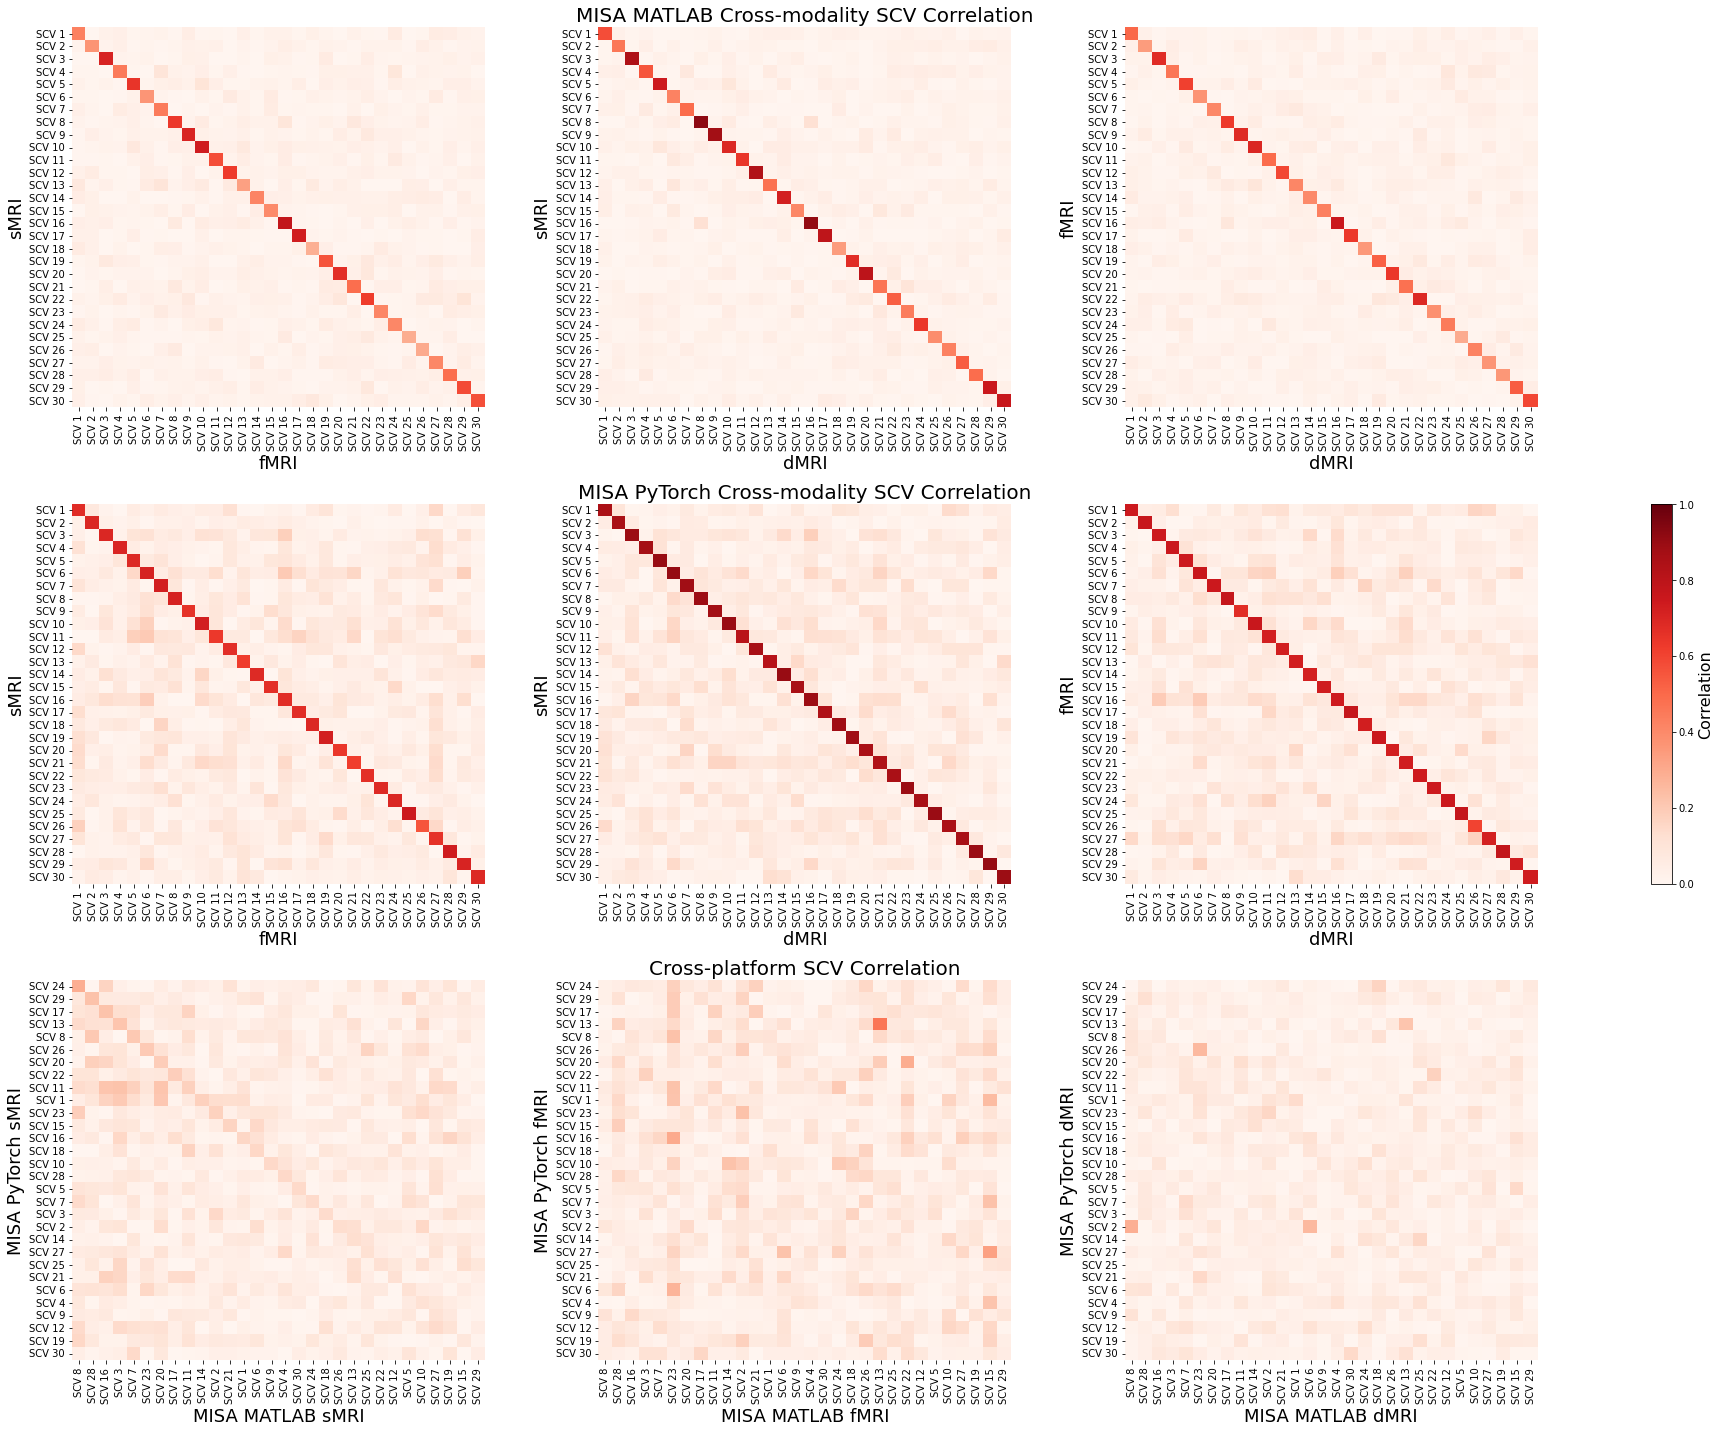

In [14]:
title_fontsize = 20
label_fontsize = 18
tick_fontsize = 16
cbar_fontsize = 16
num_row = 3
num_col = 3

fig, axes = plt.subplots(num_row, num_col+1, figsize=(23+1,20), gridspec_kw={"width_ratios":[1,1,1,0.05]})
colormap_option = "Reds"

corr_list = [[np.abs(corr_mat_smri_fmri), np.abs(corr_mat_smri_dmri), np.abs(corr_mat_fmri_dmri)], \
             [np.abs(corr_py_smri_fmri), np.abs(corr_py_smri_dmri), np.abs(corr_py_fmri_dmri)], \
             [corr_smri_sorted_abs, corr_fmri_sorted_abs, corr_dmri_sorted_abs]]
title_list = ["MISA MATLAB Cross-modality SCV Correlation", "MISA PyTorch Cross-modality SCV Correlation", "Cross-platform SCV Correlation"]
xlabel_list = [ ["fMRI", "dMRI", "dMRI"], ["fMRI", "dMRI", "dMRI"], ["MISA MATLAB sMRI", "MISA MATLAB fMRI", "MISA MATLAB dMRI"] ]
ylabel_list = [ ["sMRI", "sMRI", "fMRI"], ["sMRI", "sMRI", "fMRI"], ["MISA PyTorch sMRI", "MISA PyTorch fMRI", "MISA PyTorch dMRI"] ]
ticks = np.arange(0.5, 30.5, 1)

for j in range(num_row):
    axes[j,1].set_title(title_list[j], fontsize=title_fontsize) #fontweight="bold"
    for i in range(num_col):
      if j == 2:
        sns.heatmap(corr_list[j][i], cmap=colormap_option, cbar=False, vmin=0, vmax=1, yticklabels=python_label_list, xticklabels=matlab_label_list, ax=axes[j,i])
      else:
        sns.heatmap(corr_list[j][i], cmap=colormap_option, cbar=False, vmin=0, vmax=1, yticklabels=label_list, xticklabels=label_list, ax=axes[j,i])
      axes[j,i].set_xlabel(xlabel_list[j][i], fontsize=label_fontsize) #fontweight="bold"
      axes[j,i].set_ylabel(ylabel_list[j][i], fontsize=label_fontsize) #fontweight="bold"

cbar = fig.colorbar(axes[1,0].get_children()[0], cax=axes[1,3], orientation="vertical")
cbar.set_label('Correlation',fontsize=cbar_fontsize)
axes[0,3].axis('off')
axes[2,3].axis('off')

plt.tight_layout()
plt.savefig("corr_recovered_sources.pdf", dpi=200)
files.download("corr_recovered_sources.pdf") 